In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import load_breast_cancer

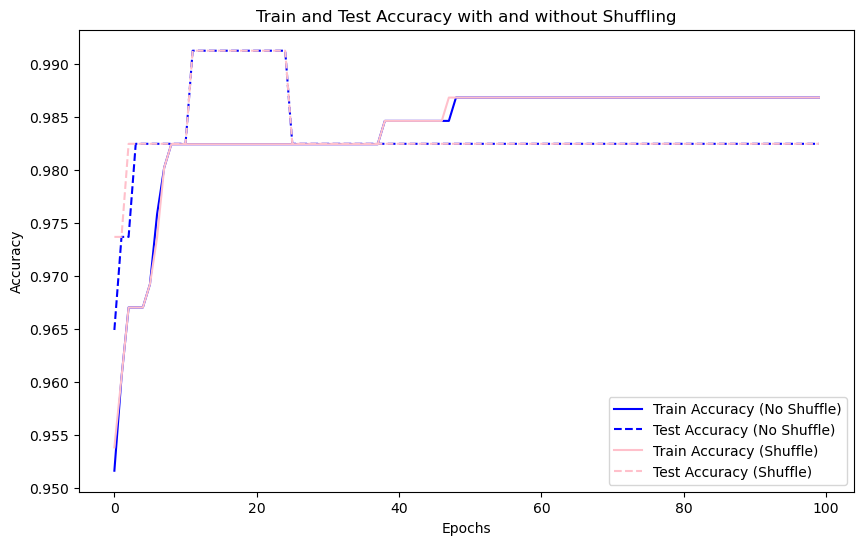

In [2]:
# Load dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Randomization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SGD Training
def train_sgd(X_train, y_train, X_test, y_test, num_epochs=100, batch_size=10, shuffle_data=False, lambda_reg=0.001, learning_rate=0.01):
    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    weights = np.zeros((n_features, n_classes))
    bias = np.zeros(n_classes)
    all_weights = [] 
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        if shuffle_data:
            indices = np.random.permutation(len(X_train))
            X_train = X_train[indices]
            y_train = y_train[indices]
        
        epoch_loss = 0
        for start_idx in range(0, len(X_train), batch_size):
            batch_indices = range(start_idx, min(start_idx + batch_size, len(X_train)))
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]

            # One-hot encoding for y_batch
            y_batch_one_hot = np.zeros((y_batch.size, n_classes))
            y_batch_one_hot[np.arange(y_batch.size), y_batch] = 1

            # Predictions
            linear_output = np.dot(X_batch, weights) + bias
            exp_scores = np.exp(linear_output - np.max(linear_output, axis=1, keepdims=True))
            predictions = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # gradients
            errors = predictions - y_batch_one_hot
            epoch_loss += np.sum(errors**2)

            # Update weights and bias (SGD with L2 regularization)
            weights -= learning_rate * (np.dot(X_batch.T, errors) + lambda_reg * weights) / batch_size
            bias -= learning_rate * np.sum(errors, axis=0) / batch_size
            
        all_weights.append(weights.copy())
        train_predictions = np.argmax(np.dot(X_train, weights) + bias, axis=1)
        train_accuracy = accuracy_score(y_train, train_predictions)

        test_predictions = np.argmax(np.dot(X_test, weights) + bias, axis=1)
        test_accuracy = accuracy_score(y_test, test_predictions)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies, all_weights

# Train and track weights for both randomization and non-randomization
train_accuracies_no_shuffle, test_accuracies_no_shuffle, weights_no_shuffle = train_sgd(X_train.copy(), y_train.copy(), X_test, y_test, shuffle_data=False, num_epochs=100, learning_rate=0.01)
train_accuracies_with_shuffle, test_accuracies_with_shuffle, weights_with_shuffle = train_sgd(X_train.copy(), y_train.copy(), X_test, y_test, shuffle_data=True, num_epochs=100, learning_rate=0.01)
epochs = np.arange(1, len(weights_no_shuffle) + 1)

# Plot the accuracies across epochs
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies_no_shuffle, label='Train Accuracy (No Shuffle)', color='blue')
plt.plot(test_accuracies_no_shuffle, label='Test Accuracy (No Shuffle)', color='blue', linestyle='--')
plt.plot(train_accuracies_with_shuffle, label='Train Accuracy (Shuffle)', color='pink')
plt.plot(test_accuracies_with_shuffle, label='Test Accuracy (Shuffle)', color='pink', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy with and without Shuffling')
plt.legend()
plt.show()

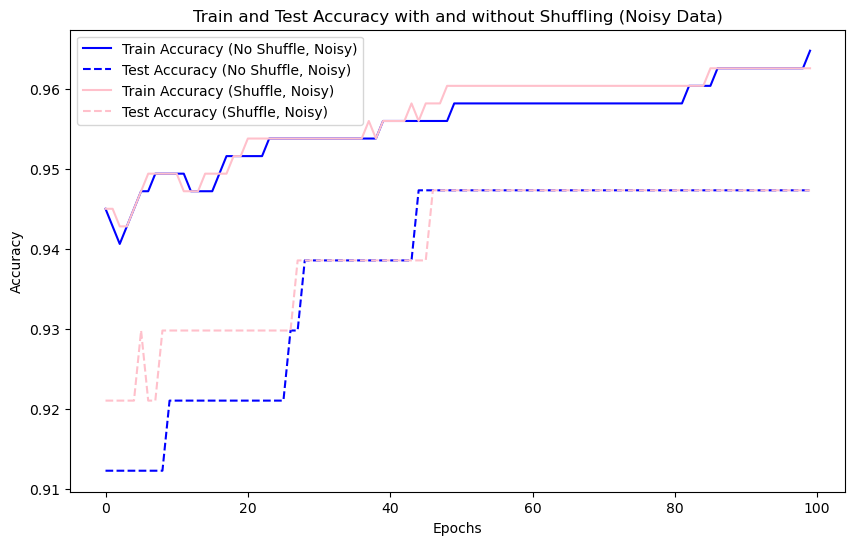

In [3]:
# Adding Gaussian noise to the dataset
def add_noise(X, noise_std=0.5, random_seed=70):
    np.random.seed(random_seed)
    noise = np.random.normal(0, noise_std, X.shape)
    X_noisy = X + noise
    return X_noisy

X_noisy = add_noise(X, noise_std=0.5)
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, y, test_size=0.2, random_state=70)
scaler_noisy = StandardScaler()
X_train_noisy = scaler_noisy.fit_transform(X_train_noisy)
X_test_noisy = scaler_noisy.transform(X_test_noisy)

train_accuracies_no_shuffle_noisy, test_accuracies_no_shuffle_noisy, weights_no_shuffle_noisy = train_sgd(
    X_train_noisy.copy(), y_train_noisy.copy(), X_test_noisy, y_test_noisy, shuffle_data=False, num_epochs=100, learning_rate=0.01
)
train_accuracies_with_shuffle_noisy, test_accuracies_with_shuffle_noisy, weights_with_shuffle_noisy = train_sgd(
    X_train_noisy.copy(), y_train_noisy.copy(), X_test_noisy, y_test_noisy, shuffle_data=True, num_epochs=100, learning_rate=0.01
)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies_no_shuffle_noisy, label='Train Accuracy (No Shuffle, Noisy)', color='blue')
plt.plot(test_accuracies_no_shuffle_noisy, label='Test Accuracy (No Shuffle, Noisy)', color='blue', linestyle='--')
plt.plot(train_accuracies_with_shuffle_noisy, label='Train Accuracy (Shuffle, Noisy)', color='pink')
plt.plot(test_accuracies_with_shuffle_noisy, label='Test Accuracy (Shuffle, Noisy)', color='pink', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy with and without Shuffling (Noisy Data)')
plt.legend()
plt.show()

In [4]:
#Function CD
def train_coordinate_descent_with_shuffle(X_train, y_train, X_test, y_test, num_epochs=100, lambda_reg=0.001, learning_rate=0.01, shuffle_data=False):
    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    weights = np.zeros((n_features, n_classes))
    bias = np.zeros(n_classes)

    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        if shuffle_data: 
            indices = np.random.permutation(len(X_train))
            X_train = X_train[indices]
            y_train = y_train[indices]

        for feature_idx in range(n_features):
            for class_idx in range(n_classes):
                linear_output = np.dot(X_train, weights) + bias
                exp_scores = np.exp(linear_output - np.max(linear_output, axis=1, keepdims=True))
                predictions = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

                y_one_hot = np.zeros((y_train.size, n_classes))
                y_one_hot[np.arange(y_train.size), y_train] = 1

                errors = predictions - y_one_hot
                gradient = np.dot(X_train[:, feature_idx], errors[:, class_idx]) / len(X_train)
                gradient += lambda_reg * weights[feature_idx, class_idx]
                weights[feature_idx, class_idx] -= learning_rate * gradient

        bias -= learning_rate * np.sum(errors, axis=0) / len(X_train)

        train_predictions = np.argmax(np.dot(X_train, weights) + bias, axis=1)
        train_accuracy = accuracy_score(y_train, train_predictions)
        test_predictions = np.argmax(np.dot(X_test, weights) + bias, axis=1)
        test_accuracy = accuracy_score(y_test, test_predictions)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies

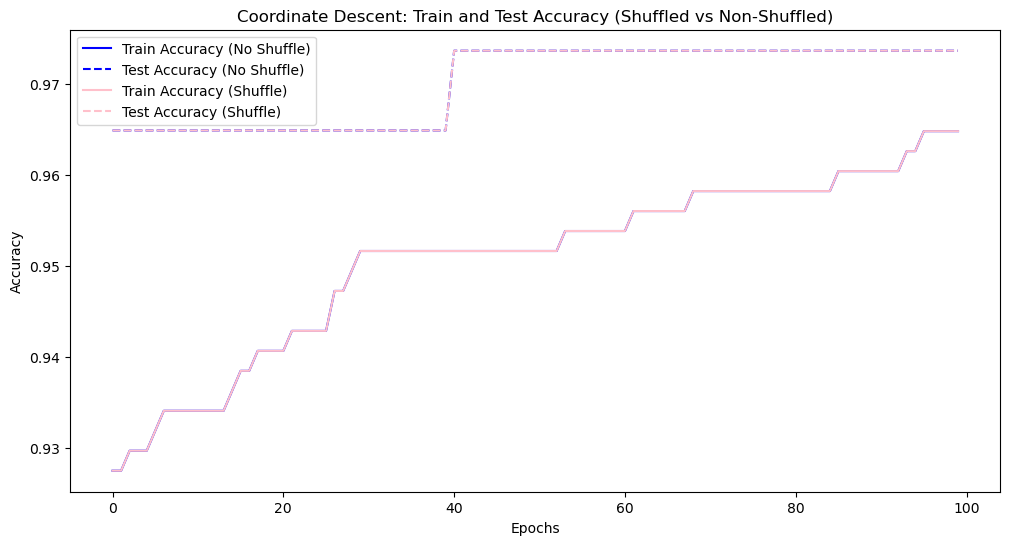

In [5]:
# Train with and without randomization
train_accuracies_cd_no_shuffle, test_accuracies_cd_no_shuffle = train_coordinate_descent_with_shuffle(
    X_train.copy(), y_train.copy(), X_test, y_test, num_epochs=100, shuffle_data=False, learning_rate=0.01
)

train_accuracies_cd_with_shuffle, test_accuracies_cd_with_shuffle = train_coordinate_descent_with_shuffle(
    X_train.copy(), y_train.copy(), X_test, y_test, num_epochs=100, shuffle_data=True, learning_rate=0.01
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies_cd_no_shuffle, label='Train Accuracy (No Shuffle)', color='blue')
plt.plot(test_accuracies_cd_no_shuffle, label='Test Accuracy (No Shuffle)', color='blue', linestyle='--')
plt.plot(train_accuracies_cd_with_shuffle, label='Train Accuracy (Shuffle)', color='pink')
plt.plot(test_accuracies_cd_with_shuffle, label='Test Accuracy (Shuffle)', color='pink', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Coordinate Descent: Train and Test Accuracy (Shuffled vs Non-Shuffled)')
plt.legend()
plt.show()

In [6]:
# Generate a synthetic classification dataset
def generate_noisy_dataset(n_samples=500, n_features=13, n_classes=3, noise_std=0.5, random_state=70):
    X, y = make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_features-2,  # Features contributing to the target
        n_redundant=0,              # Non-redundant features
        n_classes=n_classes, 
        random_state=random_state
    )
    # Add Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_std, size=X.shape)
    X_noisy = X + noise
    return X_noisy, y

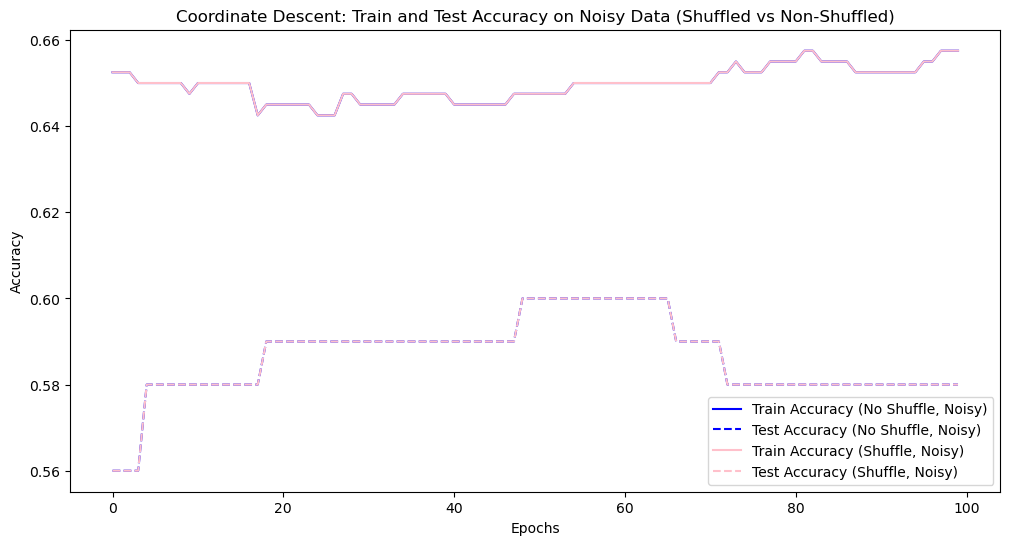

In [7]:
# Generate noisy dataset
X_noisy, y_noisy = generate_noisy_dataset()
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, y_noisy, test_size=0.2, random_state=70)
train_accuracies_cd_no_shuffle_noisy, test_accuracies_cd_no_shuffle_noisy = train_coordinate_descent_with_shuffle(
    X_train_noisy.copy(), y_train_noisy.copy(), X_test_noisy, y_test_noisy, num_epochs=100, shuffle_data=False, learning_rate=0.01
)
train_accuracies_cd_with_shuffle_noisy, test_accuracies_cd_with_shuffle_noisy = train_coordinate_descent_with_shuffle(
    X_train_noisy.copy(), y_train_noisy.copy(), X_test_noisy, y_test_noisy, num_epochs=100, shuffle_data=True, learning_rate=0.01
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies_cd_no_shuffle_noisy, label='Train Accuracy (No Shuffle, Noisy)', color='blue')
plt.plot(test_accuracies_cd_no_shuffle_noisy, label='Test Accuracy (No Shuffle, Noisy)', color='blue', linestyle='--')
plt.plot(train_accuracies_cd_with_shuffle_noisy, label='Train Accuracy (Shuffle, Noisy)', color='pink')
plt.plot(test_accuracies_cd_with_shuffle_noisy, label='Test Accuracy (Shuffle, Noisy)', color='pink', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Coordinate Descent: Train and Test Accuracy on Noisy Data (Shuffled vs Non-Shuffled)')
plt.legend()
plt.show()

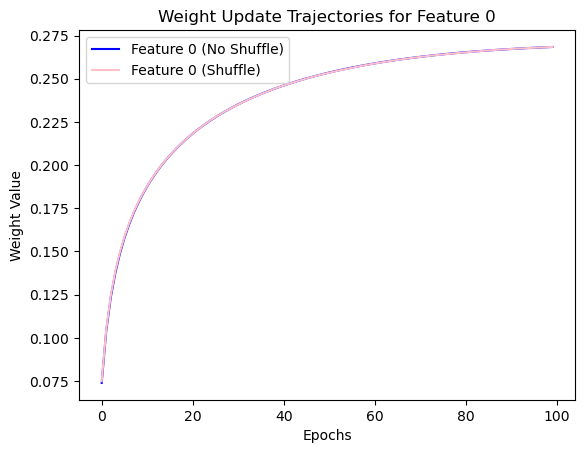

In [8]:
# Plot weight trajectories for a single feature
plt.plot([w[0, 0] for w in weights_no_shuffle], label='Feature 0 (No Shuffle)', color='blue')
plt.plot([w[0, 0] for w in weights_with_shuffle], label='Feature 0 (Shuffle)', color='pink')
plt.xlabel('Epochs')
plt.ylabel('Weight Value')
plt.legend()
plt.title('Weight Update Trajectories for Feature 0')
plt.show()

Coordinate Descent's performance is invariant to data shuffling in both low-noise and high-noise scenarios, likely due to its coordinate-specific update mechanism.

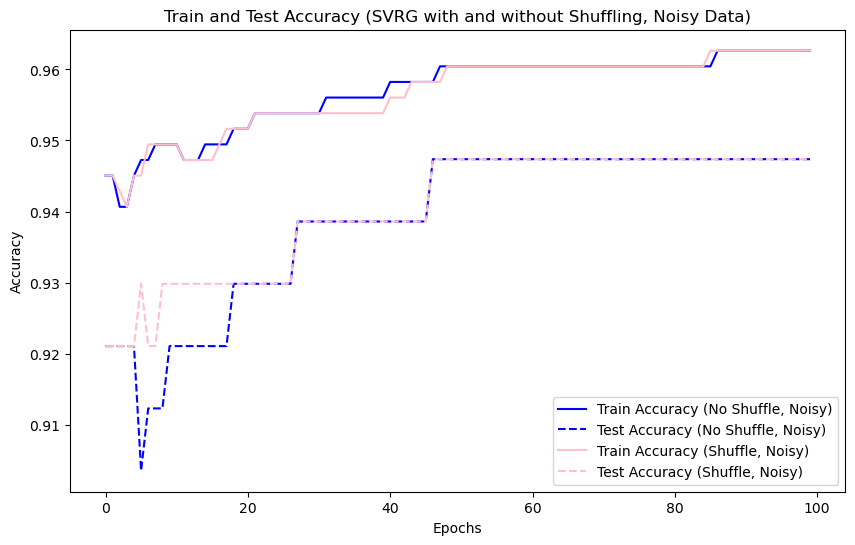

In [21]:
# SVRG with Shuffle Option
def train_svrg_with_shuffle(X_train, y_train, X_test, y_test, num_epochs=100, batch_size=10, lambda_reg=0.001, learning_rate=0.01, shuffle_data=False):
    n_samples, n_features = X_train.shape
    n_classes = len(np.unique(y_train))
    weights = np.zeros((n_features, n_classes))  # Initialize weights
    bias = np.zeros(n_classes)  # Initialize biases

    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Shuffle data if enabled
        if shuffle_data:
            indices = np.random.permutation(n_samples)
            X_train = X_train[indices]
            y_train = y_train[indices]

        # Compute full gradient at the start of the epoch
        linear_output = np.dot(X_train, weights) + bias
        exp_scores = np.exp(linear_output - np.max(linear_output, axis=1, keepdims=True))
        predictions = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        y_one_hot = np.zeros((y_train.size, n_classes))
        y_one_hot[np.arange(y_train.size), y_train] = 1

        full_gradient_weights = (np.dot(X_train.T, predictions - y_one_hot) + lambda_reg * weights) / n_samples
        full_gradient_bias = np.mean(predictions - y_one_hot, axis=0)

        # Snapshot weights and bias
        weights_snapshot = weights.copy()
        bias_snapshot = bias.copy()

        for start_idx in range(0, n_samples, batch_size):
            batch_indices = range(start_idx, min(start_idx + batch_size, n_samples))
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]

            # Batch predictions
            linear_output_batch = np.dot(X_batch, weights) + bias
            exp_scores_batch = np.exp(linear_output_batch - np.max(linear_output_batch, axis=1, keepdims=True))
            predictions_batch = exp_scores_batch / np.sum(exp_scores_batch, axis=1, keepdims=True)

            y_batch_one_hot = np.zeros((y_batch.size, n_classes))
            y_batch_one_hot[np.arange(y_batch.size), y_batch] = 1

            # Compute gradients for the batch
            grad_weights = (np.dot(X_batch.T, predictions_batch - y_batch_one_hot) + lambda_reg * weights) / batch_size
            grad_bias = np.mean(predictions_batch - y_batch_one_hot, axis=0)

            # Compute variance-reduced gradient
            linear_output_snapshot = np.dot(X_batch, weights_snapshot) + bias_snapshot
            exp_scores_snapshot = np.exp(linear_output_snapshot - np.max(linear_output_snapshot, axis=1, keepdims=True))
            predictions_snapshot = exp_scores_snapshot / np.sum(exp_scores_snapshot, axis=1, keepdims=True)

            grad_weights_snapshot = (np.dot(X_batch.T, predictions_snapshot - y_batch_one_hot) + lambda_reg * weights_snapshot) / batch_size
            grad_bias_snapshot = np.mean(predictions_snapshot - y_batch_one_hot, axis=0)

            variance_reduced_weights = grad_weights - grad_weights_snapshot + full_gradient_weights
            variance_reduced_bias = grad_bias - grad_bias_snapshot + full_gradient_bias

            # Update weights and bias
            weights -= learning_rate * variance_reduced_weights
            bias -= learning_rate * variance_reduced_bias

        # Compute accuracies for train and test sets
        train_predictions = np.argmax(np.dot(X_train, weights) + bias, axis=1)
        train_accuracy = accuracy_score(y_train, train_predictions)

        test_predictions = np.argmax(np.dot(X_test, weights) + bias, axis=1)
        test_accuracy = accuracy_score(y_test, test_predictions)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies

# Add Gaussian noise
def add_noise(X, noise_std=0.5, random_seed=70):
    np.random.seed(random_seed)
    noise = np.random.normal(0, noise_std, X.shape)
    X_noisy = X + noise
    return X_noisy

# Load and preprocess dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X_noisy = add_noise(X, noise_std=0.5)
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, y, test_size=0.2, random_state=70)
scaler_noisy = StandardScaler()
X_train_noisy = scaler_noisy.fit_transform(X_train_noisy)
X_test_noisy = scaler_noisy.transform(X_test_noisy)

# Train with SVRG (No shuffle)
train_accuracies_no_shuffle_noisy, test_accuracies_no_shuffle_noisy = train_svrg_with_shuffle(
    X_train_noisy.copy(), y_train_noisy.copy(), X_test_noisy, y_test_noisy, num_epochs=100, shuffle_data=False, learning_rate=0.01
)

# Train with SVRG (Shuffle)
train_accuracies_with_shuffle_noisy, test_accuracies_with_shuffle_noisy = train_svrg_with_shuffle(
    X_train_noisy.copy(), y_train_noisy.copy(), X_test_noisy, y_test_noisy, num_epochs=100, shuffle_data=True, learning_rate=0.01
)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies_no_shuffle_noisy, label='Train Accuracy (No Shuffle, Noisy)', color='blue')
plt.plot(test_accuracies_no_shuffle_noisy, label='Test Accuracy (No Shuffle, Noisy)', color='blue', linestyle='--')
plt.plot(train_accuracies_with_shuffle_noisy, label='Train Accuracy (Shuffle, Noisy)', color='pink')
plt.plot(test_accuracies_with_shuffle_noisy, label='Test Accuracy (Shuffle, Noisy)', color='pink', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy (SVRG with and without Shuffling, Noisy Data)')
plt.legend()
plt.show()


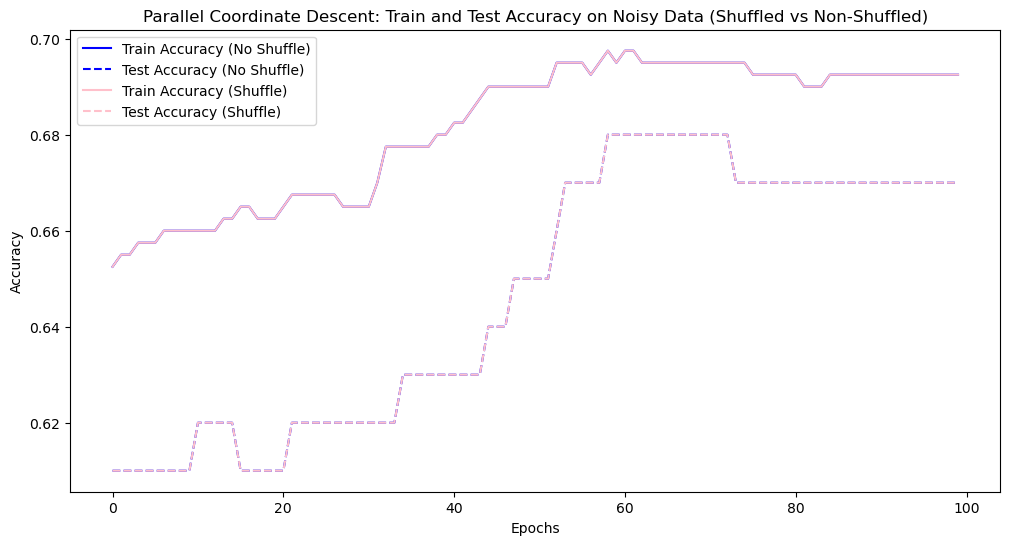

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Parallel Coordinate Descent Function
def train_parallel_coordinate_descent_with_shuffle(X_train, y_train, X_test, y_test, num_epochs=100, lambda_reg=0.001, learning_rate=0.01, shuffle_data=False):
    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    weights = np.zeros((n_features, n_classes))
    bias = np.zeros(n_classes)

    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        if shuffle_data: 
            indices = np.random.permutation(len(X_train))
            X_train = X_train[indices]
            y_train = y_train[indices]

        # Update weights and biases in parallel
        linear_output = np.dot(X_train, weights) + bias
        exp_scores = np.exp(linear_output - np.max(linear_output, axis=1, keepdims=True))
        predictions = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        y_one_hot = np.zeros((y_train.size, n_classes))
        y_one_hot[np.arange(y_train.size), y_train] = 1

        errors = predictions - y_one_hot
        for feature_idx in range(n_features):
            gradient = np.dot(X_train[:, feature_idx], errors) / len(X_train)
            gradient += lambda_reg * weights[feature_idx]
            weights[feature_idx] -= learning_rate * gradient

        bias_gradient = np.sum(errors, axis=0) / len(X_train)
        bias -= learning_rate * bias_gradient

        # Calculate accuracies
        train_predictions = np.argmax(np.dot(X_train, weights) + bias, axis=1)
        train_accuracy = accuracy_score(y_train, train_predictions)
        test_predictions = np.argmax(np.dot(X_test, weights) + bias, axis=1)
        test_accuracy = accuracy_score(y_test, test_predictions)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies

# Generate a noisy dataset
def generate_noisy_dataset(n_samples=500, n_features=13, n_classes=3, noise_std=0.5, random_state=70):
    X, y = make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_features-2,  # Features contributing to the target
        n_redundant=0,              # Non-redundant features
        n_classes=n_classes, 
        random_state=random_state
    )
    # Add Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_std, size=X.shape)
    X_noisy = X + noise
    return X_noisy, y

# Generate noisy dataset
X_noisy, y_noisy = generate_noisy_dataset()
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, y_noisy, test_size=0.2, random_state=70)

# Train with and without randomization
train_accuracies_cd_no_shuffle, test_accuracies_cd_no_shuffle = train_parallel_coordinate_descent_with_shuffle(
    X_train_noisy.copy(), y_train_noisy.copy(), X_test_noisy, y_test_noisy, num_epochs=100, shuffle_data=False, learning_rate=0.01
)

train_accuracies_cd_with_shuffle, test_accuracies_cd_with_shuffle = train_parallel_coordinate_descent_with_shuffle(
    X_train_noisy.copy(), y_train_noisy.copy(), X_test_noisy, y_test_noisy, num_epochs=100, shuffle_data=True, learning_rate=0.01
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies_cd_no_shuffle, label='Train Accuracy (No Shuffle)', color='blue')
plt.plot(test_accuracies_cd_no_shuffle, label='Test Accuracy (No Shuffle)', color='blue', linestyle='--')
plt.plot(train_accuracies_cd_with_shuffle, label='Train Accuracy (Shuffle)', color='pink')
plt.plot(test_accuracies_cd_with_shuffle, label='Test Accuracy (Shuffle)', color='pink', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Parallel Coordinate Descent: Train and Test Accuracy on Noisy Data (Shuffled vs Non-Shuffled)')
plt.legend()
plt.show()